In [24]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [25]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

### Custom pipeline for dat pre-processing

In [28]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary'):
        self.label_encode = label_encode
        self.process_label = process_label
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)    

        return df

In [29]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [30]:
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Multi')
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Multi')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

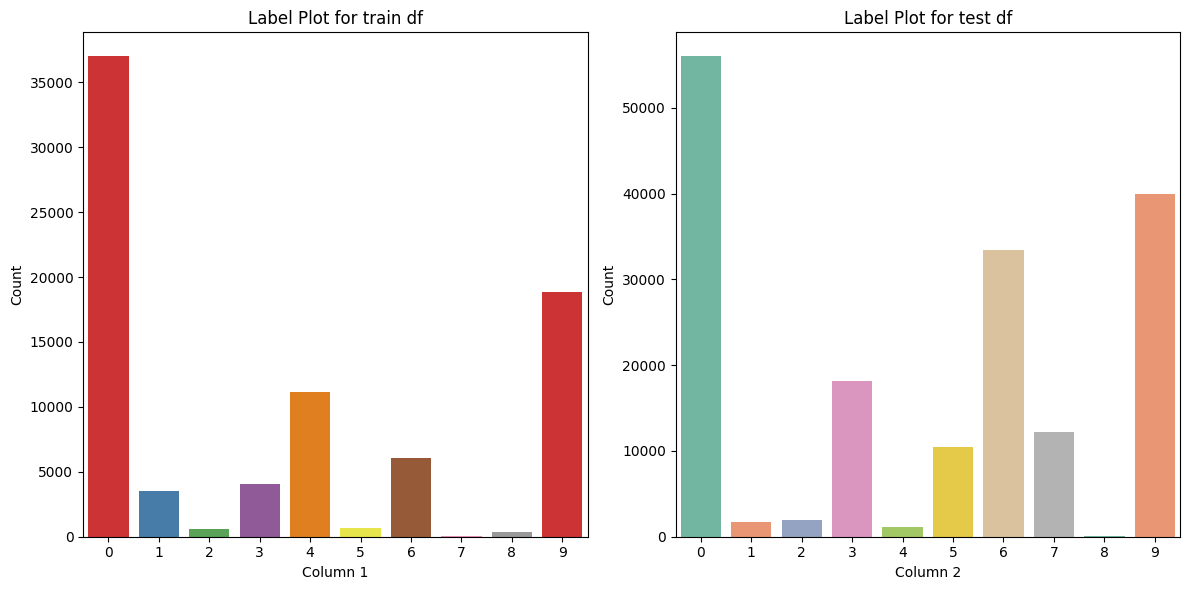

In [31]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [32]:
combined_df = pd.concat([train_df, test_df])
shuffled_df = combined_df.sample(frac=1, random_state=42)
split_ratio = 0.3
split_index = int(len(shuffled_df) * split_ratio)

train_df = shuffled_df[:split_index]
test_df = shuffled_df[split_index:]

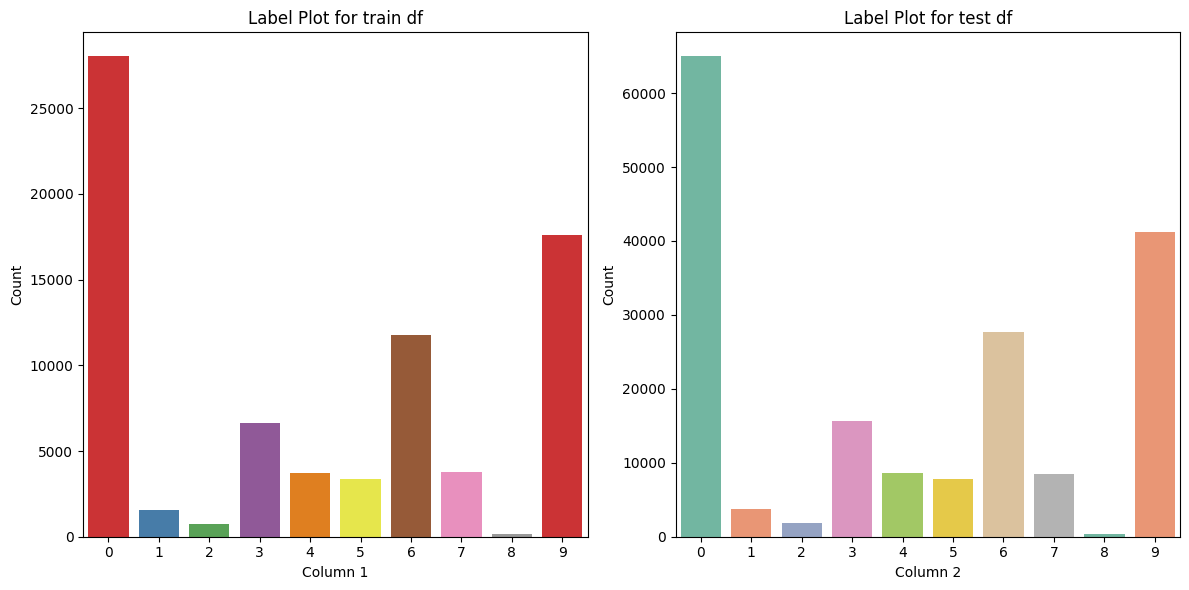

In [33]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

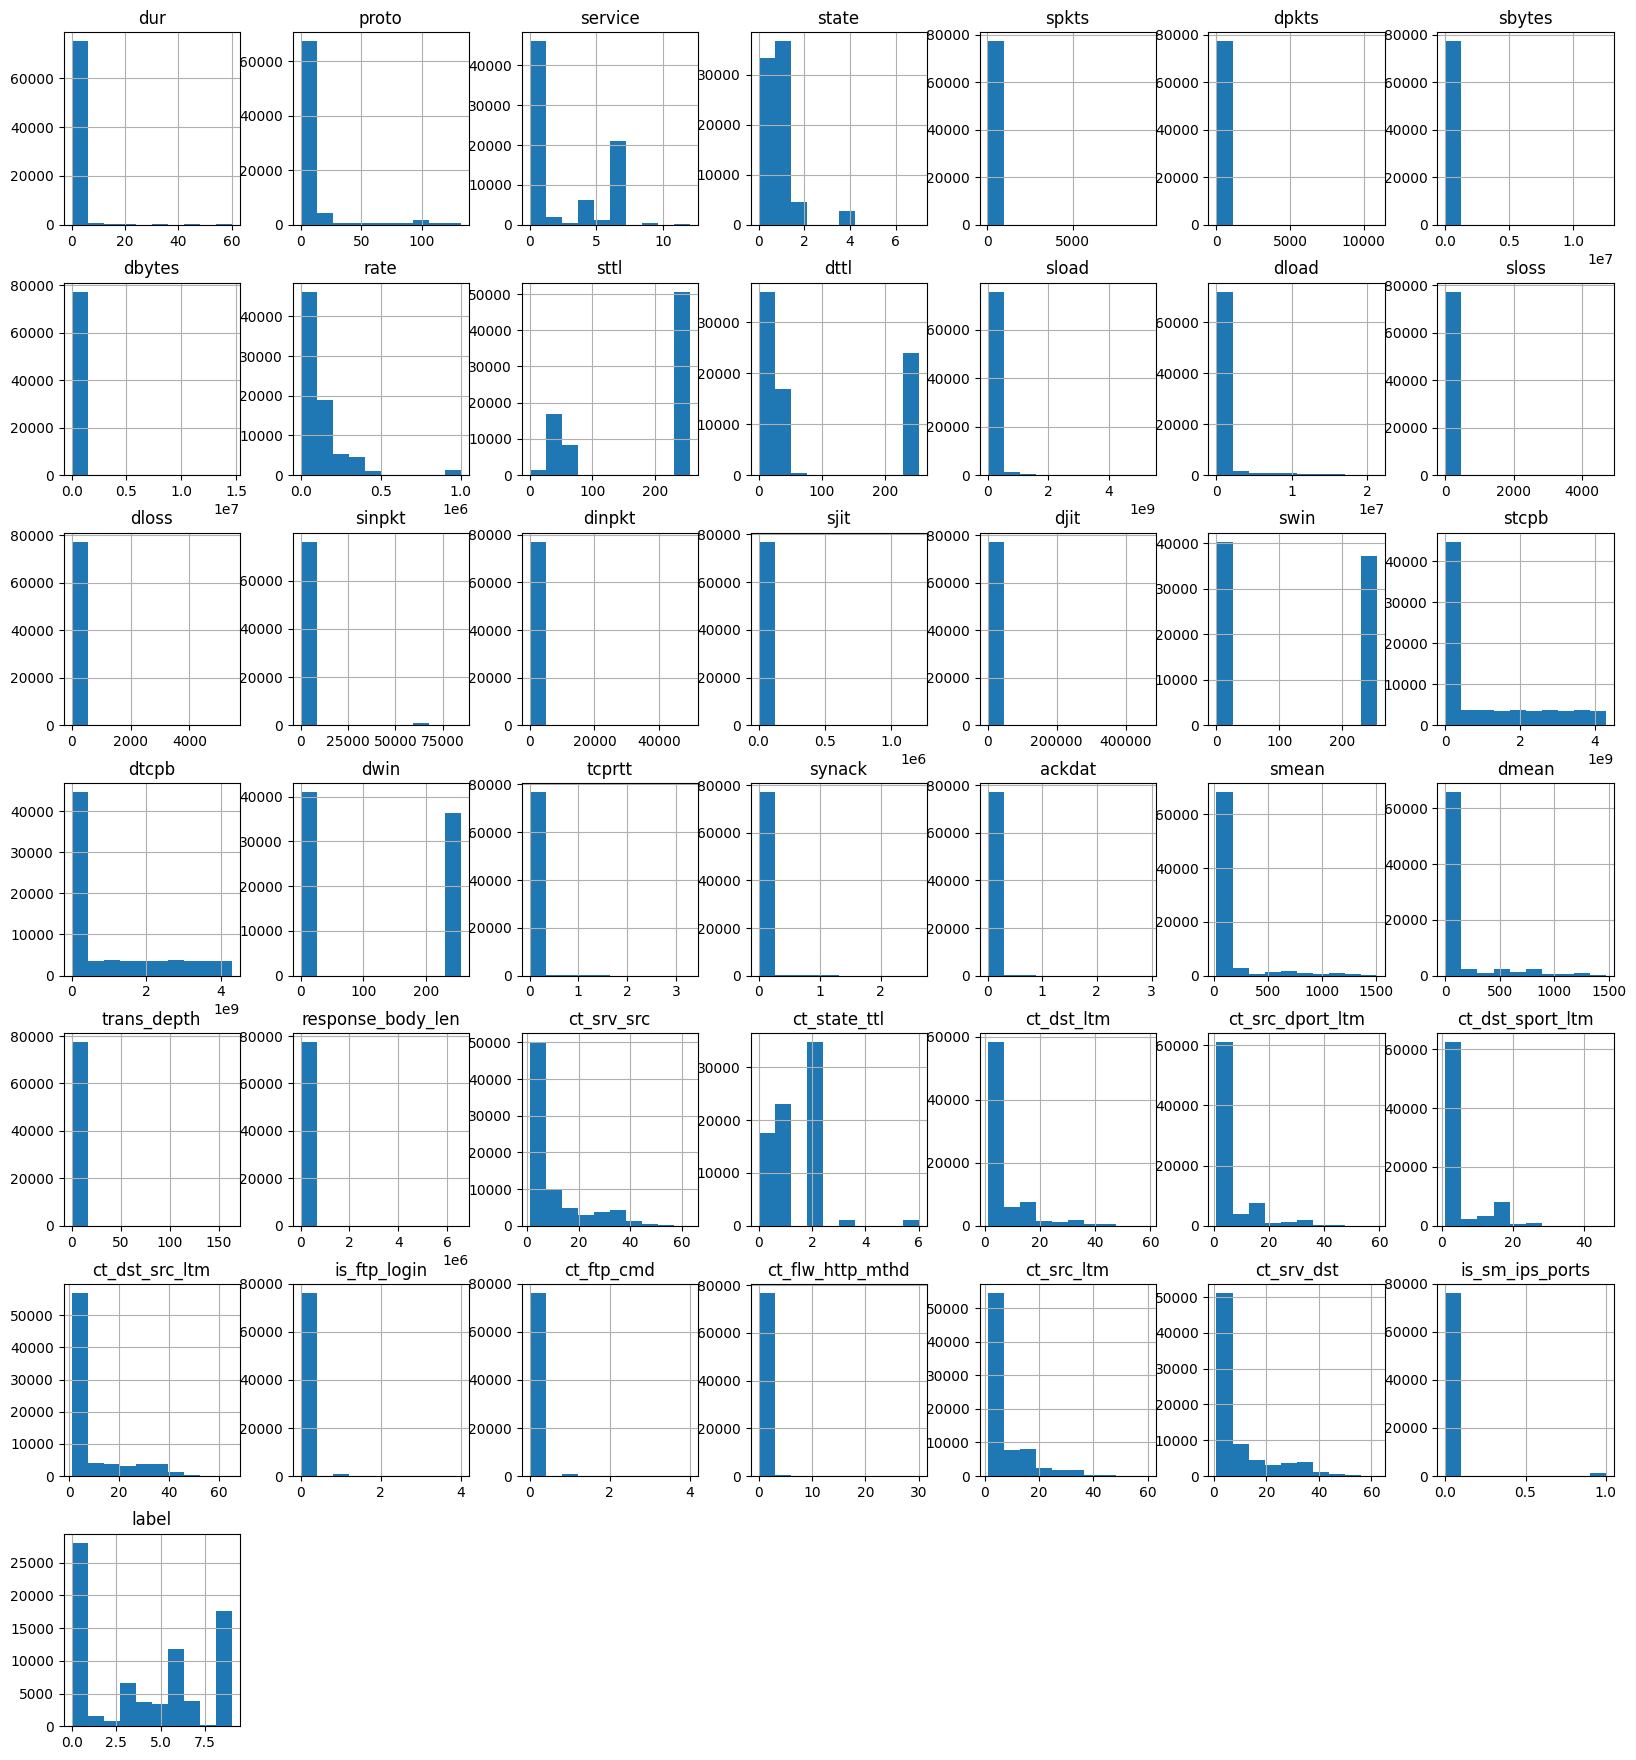

In [34]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

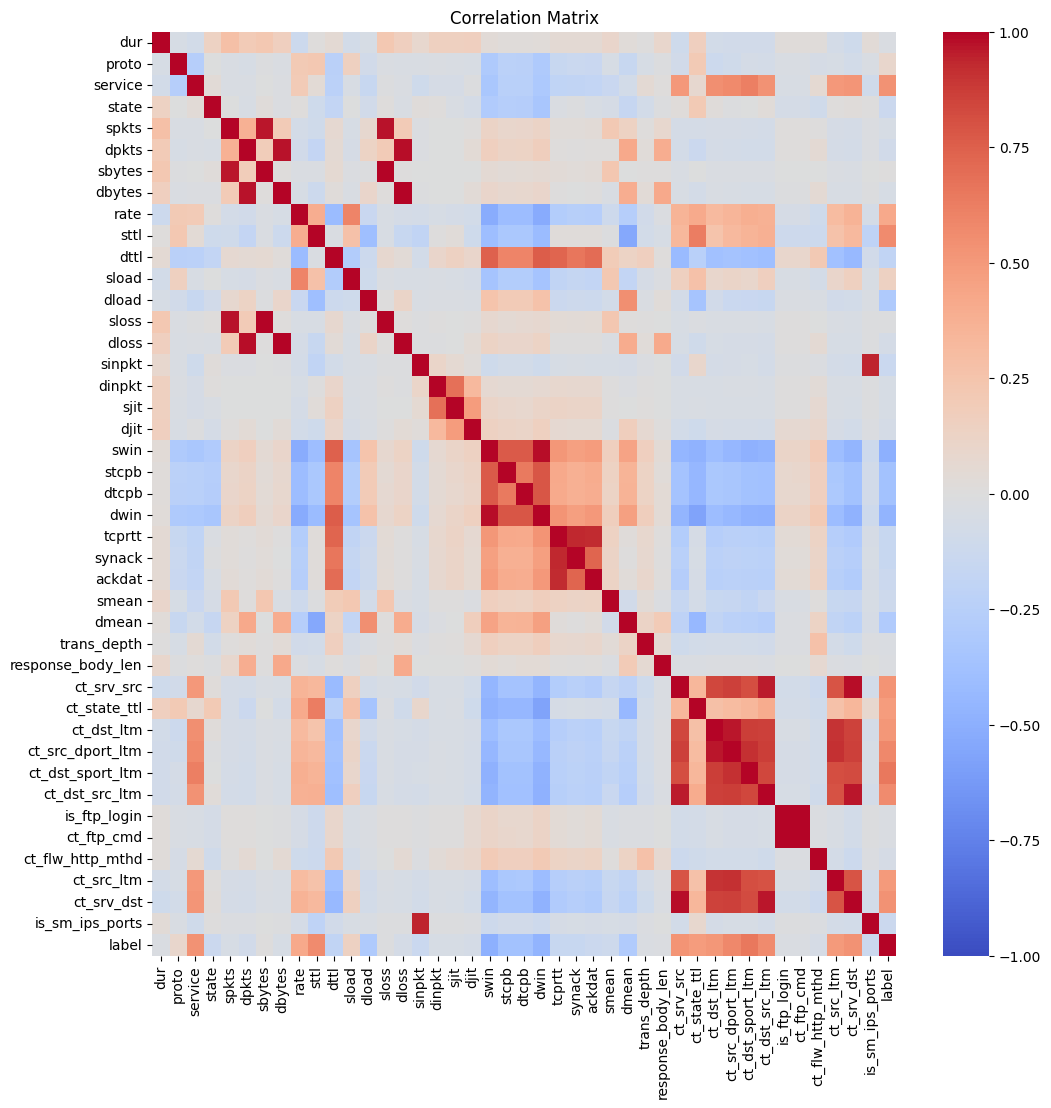

In [35]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [36]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in target_corr_abs.items():
    print(f"{attribute}: {correlation:.4f}")

dur: 0.0301
proto: 0.0925
service: 0.5357
state: 0.1268
spkts: 0.0522
dpkts: 0.0919
sbytes: 0.0056
dbytes: 0.0537
rate: 0.4187
sttl: 0.5661
dttl: 0.1906
sload: 0.1476
dload: 0.2992
sloss: 0.0117
dloss: 0.0692
sinpkt: 0.1342
dinpkt: 0.0499
sjit: 0.0507
djit: 0.0672
swin: 0.4960
stcpb: 0.3714
dtcpb: 0.3699
dwin: 0.4736
tcprtt: 0.1556
synack: 0.1558
ackdat: 0.1324
smean: 0.1169
dmean: 0.2936
trans_depth: 0.0280
response_body_len: 0.0181
ct_srv_src: 0.5263
ct_state_ttl: 0.4850
ct_dst_ltm: 0.5135
ct_src_dport_ltm: 0.5843
ct_dst_sport_ltm: 0.6494
ct_dst_src_ltm: 0.5666
is_ftp_login: 0.0240
ct_ftp_cmd: 0.0243
ct_flw_http_mthd: 0.0582
ct_src_ltm: 0.4929
ct_srv_dst: 0.5342
is_sm_ips_ports: 0.1327
label: 1.0000


In [37]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

In [38]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

In [39]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

In [40]:
# Pipeline example
pipeline = SparkDFPipeline(standardize=True)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

# ANN model

In [41]:
input_length = len(train.select('features').collect()[0][0])
output_length = train.select('label').distinct().count()

In [42]:
mlp = MultilayerPerceptronClassifier(seed=42, maxIter=100, stepSize=0.001)
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

paramGrid = ParamGridBuilder() \
             .addGrid(mlp.layers, [
                    [input_length, 26, 17, output_length],
                    [input_length, 25, 19, output_length],
                 # Add more layer combinations as needed
             ]) \
             .build()

crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

cv_model = crossval.fit(train)
best_model = cv_model.bestModel
best_params = best_model.extractParamMap()

In [43]:
# 32/16 52
#
# Create a list of parameter names and their corresponding values
param_list = [(param.name, value) for param, value in best_params.items()]

# Convert the list to a formatted string
shortened_output = "\n".join([f"{param}: {value}" for param, value in param_list])

print(shortened_output)

blockSize: 128
featuresCol: features
labelCol: label
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: 42
solver: l-bfgs
stepSize: 0.001
tol: 1e-06
layers: [42, 26, 17, 10]


In [44]:
# Define your class labels
from sklearn.metrics import confusion_matrix, classification_report
class_labels = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']
num_classes = len(class_labels)
def evaluate_model(model, val_data, model_name):
    # Make predictions on the validation data
        predictions = model.transform(val_data)
        acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = acc_evaluator.evaluate(predictions)

        f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        f1_score = f1_evaluator.evaluate(predictions)

        # Calculate Area Under Precision-Recall Curve using BinaryClassificationEvaluator
        # pr_evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
        # area_under_pr = pr_evaluator.evaluate(predictions)

        # Calculate True Positives, True Negatives, False Positives, and False Negatives
        precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        precision_score = precision_evaluator.evaluate(predictions)

        recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
        recall_score = recall_evaluator.evaluate(predictions)

        y_true = predictions.select('label').rdd.flatMap(lambda x: x).collect()
        y_pred = predictions.select('prediction').rdd.flatMap(lambda x: x).collect()

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 12))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
        plt.title('Confusion Matrix')
        plt.colorbar()
        tick_marks = np.arange(num_classes)
        plt.xticks(tick_marks, range(num_classes))
        plt.yticks(tick_marks, range(num_classes))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

        for i in range(num_classes):
            for j in range(num_classes):
                plt.text(j, i, str(cm[i, j]), horizontalalignment="center", verticalalignment="center")

        plt.show()


        # Create a dictionary of model evaluation metrics
        eval_metrics = {
            'Accuracy': accuracy
            , 'F1 Score': f1_score
            # , 'Area Under ROC': AUC_score
            # , 'Area Under PR': AUPR_score
            , 'Precision': precision_score
            , 'Recall': recall_score
        }

        return eval_metrics

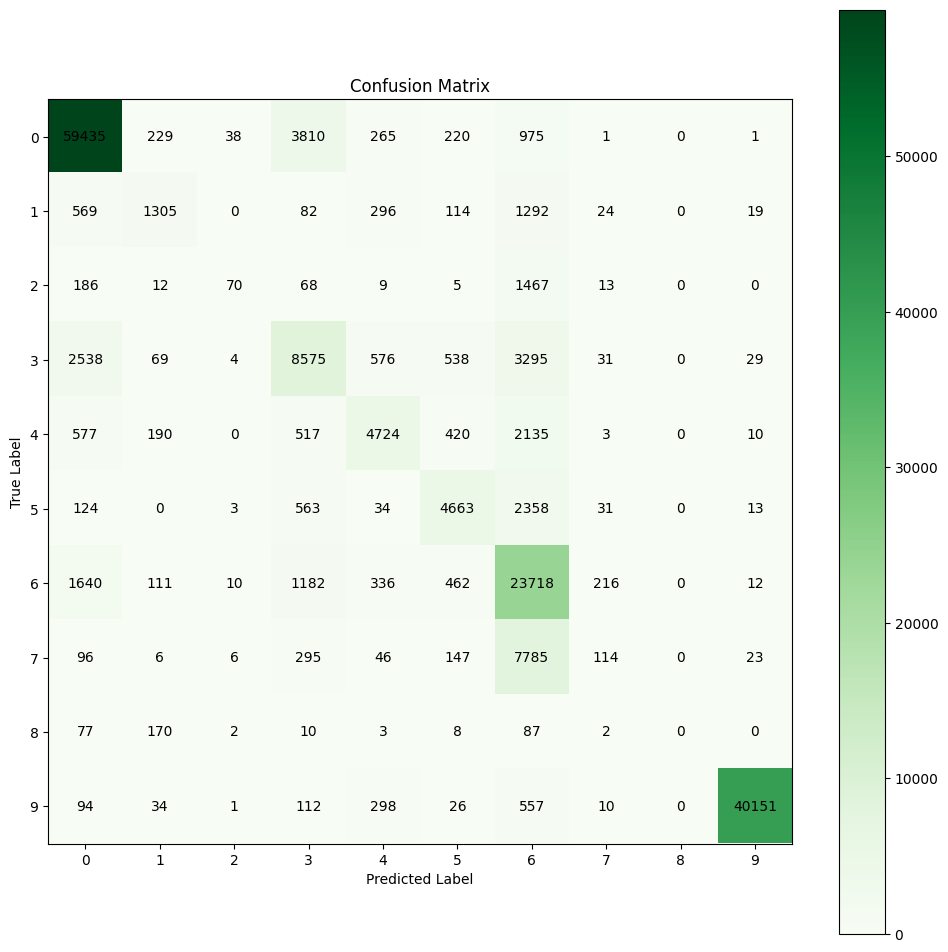

Evaluation Results:
Metric              ANN Model           
Accuracy            0.791448            
F1 Score            0.772984            
Precision           0.782833            
Recall              0.791448            


In [45]:
# Model evaluation
evaluation_results_ANN = evaluate_model(best_model, test, 'ANN Model')

print("Evaluation Results:")
print(f"{'Metric':<20}{'ANN Model':<20}")
print("=" * 60)

for metric in evaluation_results_ANN.keys():
    default_value = evaluation_results_ANN[metric]
    print(f"{metric:<20}{default_value:<20.6f}")